##Import relevant libararies

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor , StackingRegressor ,VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable


fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: 
https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing

CHANGES T
CELL 1:
    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
    # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
    !python rapidsai-csp-utils/colab/env-check.py

CELL 2:
 

##Loading the data

In [3]:
from google.colab import files
uploaded = files.upload() # upload kaggle.json
'''
if you are using google colab an you don't have your kaggle.json file
please go to your kaggle profile-> settings-> API -> create API token -> download it
then run this cell for once
'''
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
from pathlib import Path
import zipfile
import pandas as pd

def download_diamonds_data():
  ! kaggle competitions download -c diamond-price-prediciton-2024
  zip_path = Path("diamond-price-prediciton-2024.zip")
  with zipfile.ZipFile(zip_path) as diamonds_zip:
    diamonds_zip.extractall()

  diamonds_train = pd.read_csv(Path('train.csv'),index_col=0)
  diamonds_test = pd.read_csv(Path('test.csv'))
  return diamonds_train , diamonds_test


In [3]:
diamonds_train ,diamonds_test= download_diamonds_data()

diamond-price-prediciton-2024.zip: Skipping, found more recently modified local copy (use --force to force download)


##Taking a quick look on data:

In [6]:
diamonds_train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
Id,,,,,,,,,,
1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [7]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43152 entries, 1 to 43152
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43152 non-null  float64
 8   y        43152 non-null  float64
 9   z        43152 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.6+ MB


In [18]:
diamonds_train.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


##Data Splitting

All columns are numerical except for cut, color, and clarity, which are strings. Also, the data contains no missing values! That's great news.

In [7]:
diamonds = diamonds_train
diamonds_labels = diamonds_train.price
diamonds_cat = diamonds_train.select_dtypes(include=[np.object_])
diamonds_num = diamonds_train.select_dtypes(include=[np.number])# price is in  diamonds_num
diamonds_num.head()

,carat,depth,table,price,x,y,z
Id,,,,,,,
1,1.06,61.8,57.0,4270,6.57,6.60,4.07
2,1.51,60.9,58.0,15164,7.38,7.42,4.51
3,0.32,61.3,56.0,828,4.43,4.41,2.71
4,0.53,61.2,56.0,1577,5.19,5.22,3.19
5,0.70,61.0,57.0,2596,5.76,5.72,3.50


Taking a look on distributions.

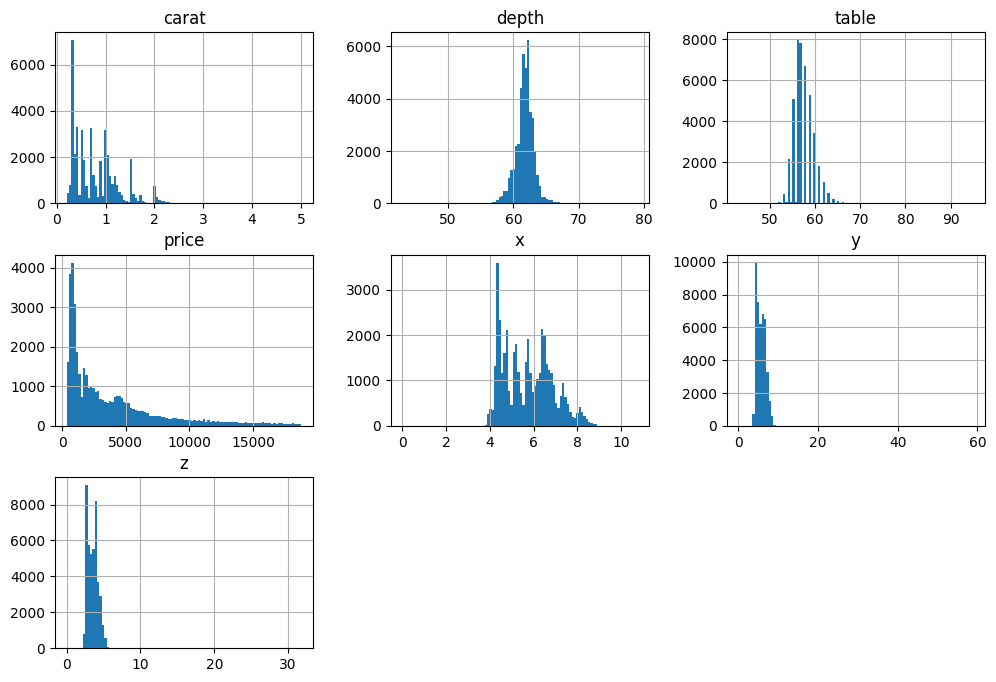

In [20]:
diamonds_train.hist(bins = 100 , figsize=(12,8))
plt.show()

Taking a look on scatter plots.

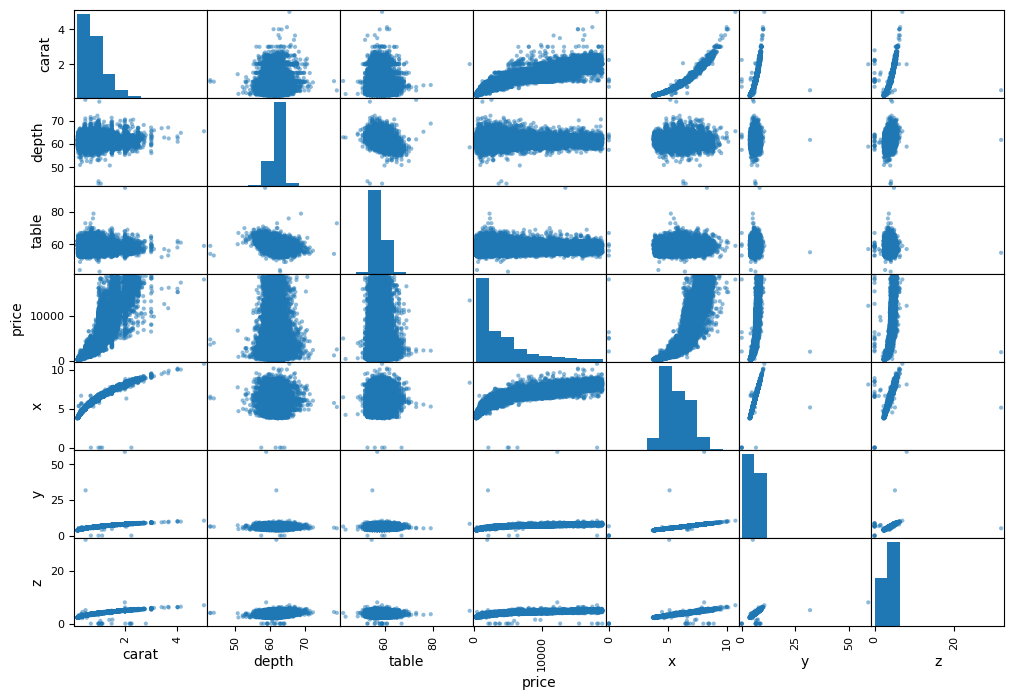

In [21]:
from pandas.plotting import scatter_matrix

scatter_matrix(diamonds_num , figsize=(12,8))
plt.show()

##Handling numerical data.

Looking for correlations.

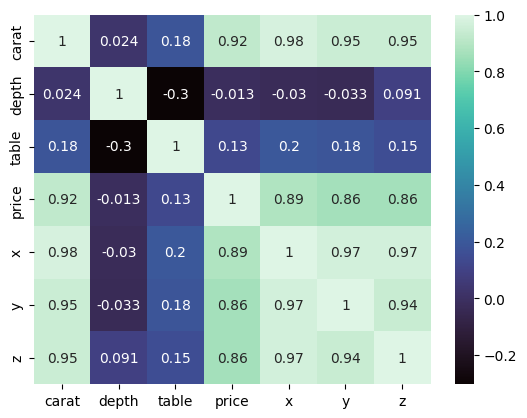

In [22]:
corr_matrix = diamonds_num.corr()
sns.heatmap(corr_matrix,annot=True , cmap='mako')

plt.show()

`x`,`y`,`z`,`carat` columns are highly correlated to the price column, while

For the depth column, there is no correlation at all, will work through to try to fix this issue without dropping this column.

We will try to group the depth column in clusters, then we will calculate the similarities to the cluster centers to see if it is doing better than depth column.

In [4]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):

    def __init__(self, n_clusters=25, gamma=1.0, random_state=42):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [11]:
cluster_simil = ClusterSimilarity(n_clusters=5, gamma=1., random_state=42)
depth = diamonds.depth.to_numpy().reshape(-1,1)

similarities = cluster_simil.fit_transform(depth,
 sample_weight=diamonds_labels)

In [12]:
sim = pd.DataFrame(similarities , columns=[f'cluster {i}' for i in range(similarities.shape[1])],index = diamonds_labels.index)
sim_price = pd.merge(left=sim,right = diamonds_labels, left_index =True,right_index=True)
sim_price.corr()['price'].sort_values(ascending=False)

price        1.000000
cluster 1    0.054099
cluster 3    0.020444
cluster 0    0.013288
cluster 2   -0.039639
cluster 4   -0.050827
Name: price, dtype: float64

In [13]:
diamonds.depth.corr(diamonds_labels)

-0.013137002552388215

the cluster similaraties are doing a little bit better than the original depth column.

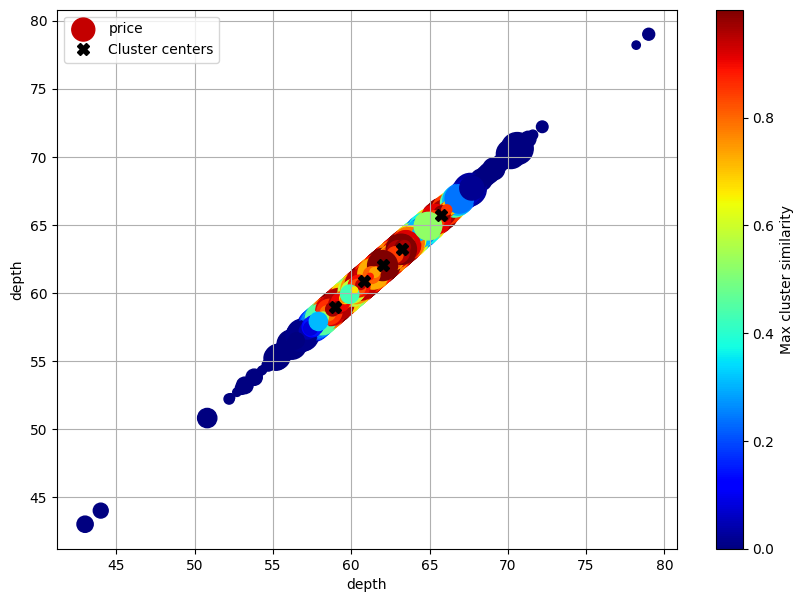

In [14]:
diamonds_copy = diamonds.copy()
diamonds_copy["Max cluster similarity"] = similarities.max(axis=1)
diamonds_copy.plot(kind="scatter", x="depth", y='depth', grid=True,
                          s=diamonds_labels / 35, label="price",
                          c="Max cluster similarity",
                          cmap="jet", colorbar=True,
                          legend=True, sharex=False, figsize=(10, 7))
plt.plot( cluster_simil.kmeans_.cluster_centers_[:],
          cluster_simil.kmeans_.cluster_centers_[:],
         linestyle="", color="black", marker="X", markersize=8,
         label="Cluster centers")
plt.legend(loc="upper left")
plt.show()

The plot shows the clusters found by the k-means algorithm. We can clearly see that most of the cluster centers are located among the expensive diamonds with a total depth range of approximately [58 - 68].

Now for the rest of the numerical columns,we will use the StandardScaler Transformer

In [15]:
std_scaler = StandardScaler()
diamonds_num_std_scaled = std_scaler.fit_transform(diamonds_num.drop(['price'],axis=1))
diamonds_num_std_scaled[0]

array([ 0.55352944,  0.03679895, -0.20518007,  0.74775484,  0.75294733,
        0.75036741])

We will build a transformer to claculate the volume feature from x,y and z.

In [38]:
class VolumeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self , with_volume= True):
        self.with_volume = with_volume

    def fit(self, X, y=None):
        self.volume_std = (X['x']* X['y']* X['z']).std()
        self.volume_mean = (X['x']* X['y']* X['z']).mean()
        self.x_std = X['x'].std()
        self.y_std = X['y'].std()
        self.z_std = X['z'].std()

        self.x_mean = X['x'].mean()
        self.y_mean = X['y'].mean()
        self.z_mean = X['z'].mean()
        return self

    def transform(self, X):
        if self.with_volume:
            X['volume'] = X['x'] * X['y'] * X['z']
            X['vloume'] = (X['volume'] - self.volume_mean)/ self.volume_std
            X.drop(['x','y','z'] ,axis=1 ,inplace = True)
            return X
        else:
           X['x'] = (X['x'] - self.x_mean)/self.x_std
           X['y'] = (X['y'] - self.y_mean)/self.y_std
           X['z'] = (X['z'] - self.z_mean)/self.z_std
           return X


# handling categorical text

In [16]:
cats = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    sorted(diamonds_cat.color.unique(), reverse=True),
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
]
ordinal_encoder = OrdinalEncoder(categories=cats)
diamonds_cat_ordinal = ordinal_encoder.fit_transform(diamonds_cat)
dimonds_cat_ordinal_df = pd.DataFrame(diamonds_cat_ordinal , columns = diamonds_cat.columns.values)
dimonds_cat_ordinal_df.head(2)

,cut,color,clarity
0,4.0,1.0,1.0
1,3.0,3.0,5.0


In [38]:
diamonds_cat.head(2)

,cut,color,clarity
Id,,,
1,Ideal,I,SI2
2,Premium,G,VVS2


##Making the Pipeline

In [39]:
volume_attribs = ['x','y','z']
depth_atrrib = ['depth']
num_attribs =['carat', 'table']
cat_attribs = ['cut','color', 'clarity']
cats = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    sorted(diamonds_cat.color.unique(), reverse=True),
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
]

volume_tranformer = VolumeTransformer()
cluster_simil = ClusterSimilarity(
    n_clusters=5, gamma=1., random_state=42)

num_pipeline = make_pipeline(
        StandardScaler())

cat_pipeline = make_pipeline(
        OrdinalEncoder(categories=cats))

preprocessing = ColumnTransformer([
 ("Volume",  volume_tranformer, volume_attribs),
 ("depth_cluster", cluster_simil, depth_atrrib),
 ("num",        num_pipeline,     num_attribs),
 ("cat",        cat_pipeline,     cat_attribs),
])


##Select and Train the model

In [9]:
# Linear Regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(diamonds, diamonds_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('depth_cluster',
                                                  ClusterSimilarity(n_clusters=5),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('linearregression', LinearRegression())])

In [10]:
lin_pred = lin_reg.predict(diamonds)
predictions = lin_reg.predict(diamonds_test)

lin_mae = mae(diamonds_labels , lin_pred)
lin_mae

803.7763664659566

In [11]:
lin_scores = -cross_val_score(lin_reg,diamonds,diamonds_labels,cv=5,scoring='neg_mean_absolute_error')

In [12]:
pd.DataFrame(lin_scores).describe()

,0
count,5.000000
mean,806.622221
std,5.817794
min,802.140175
25%,802.435990
50%,803.179796
75%,810.168713
max,815.186433


In [13]:
# Tree Regression
tree_reg = make_pipeline(preprocessing,
                         DecisionTreeRegressor(criterion = 'absolute_error',
                                               ))
tree_reg.fit(diamonds, diamonds_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('depth_cluster',
                                                  ClusterSimilarity(n_clusters=5),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(criterion='absolute_error'))])

In [14]:
preds = tree_reg.predict(diamonds)

predictions = tree_reg.predict(diamonds_test)
tree_mae= mae(diamonds_labels , preds)
tree_mae



0.4282999629217649

In [15]:
tree_scores = -cross_val_score(tree_reg,diamonds,diamonds_labels,cv=5,scoring='neg_mean_absolute_error')

In [16]:
pd.DataFrame(tree_scores).describe()

,0
count,5.000000
mean,374.982836
std,10.475684
min,359.929035
25%,370.633314
50%,377.992063
75%,378.180591
max,388.179180


In [17]:
# SVM Regression
lin_svm = make_pipeline(preprocessing,
                       LinearSVR(C = 1000,epsilon = 5 ,dual =True ,max_iter=3000))
lin_svm.fit(diamonds ,diamonds_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('depth_cluster',
                                                  ClusterSimilarity(n_clusters=5),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('linearsvr', LinearSVR(C=1000, epsilon=5, max_iter=3000))])

In [18]:
svm_pred = lin_svm.predict(diamonds)
predictions = lin_svm.predict(diamonds)

svm_mae = mae(diamonds_labels ,svm_pred )
svm_mae

700.2459166593178

In [19]:
svm_scores = -cross_val_score(lin_svm,diamonds,diamonds_labels,cv=5,scoring='neg_mean_absolute_error')

In [20]:
pd.DataFrame(svm_scores).describe()

,0
count,5.000000
mean,701.199052
std,3.636916
min,698.077078
25%,698.747218
50%,700.510218
75%,701.409278
max,707.251467


In [21]:
# Random Forest Regression
rf_reg = make_pipeline(preprocessing, RandomForestRegressor())
rf_reg.fit(diamonds, diamonds_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('depth_cluster',
                                                  ClusterSimilarity(n_clusters=5),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               'G',
                                                                                               'F',
                                                                                               'E',
                                                                                               'D'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']]))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [22]:
rf_pred = rf_reg.predict(diamonds)
predictions = rf_reg.predict(diamonds_test)

rf_mae = mae(diamonds_labels , rf_pred )
rf_mae

99.36968955695922

In [23]:
rf_scores = -cross_val_score(rf_reg,diamonds,diamonds_labels,cv=5,scoring='neg_mean_absolute_error')
pd.DataFrame(rf_scores).describe()

,0
count,5.000000
mean,272.225318
std,3.421969
min,268.242281
25%,269.685747
50%,272.796834
75%,273.399324
max,277.002405


In [24]:
# XGB Regression
xgb_reg = make_pipeline(preprocessing, XGBRegressor())
xgb_reg.fit(diamonds, diamonds_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('depth_cluster',
                                                  ClusterSimilarity(n_clusters=5),
                                                  ['depth']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'table', 'x', 'y',
                                                   'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['J',
                                                                                               'I',
                                                                                               'H',
                                                                                               '...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [25]:
xgb_pred = xgb_reg.predict(diamonds)
xgb_mae = mae(diamonds_labels ,xgb_pred )
xgb_mae

219.67775644281858

In [26]:
xgb_scores = -cross_val_score(xgb_reg,diamonds,diamonds_labels,cv=5,scoring='neg_mean_absolute_error')
pd.DataFrame(xgb_scores).describe()

,0
count,5.000000
mean,280.971600
std,3.127050
min,277.420621
25%,278.092409
50%,281.692736
75%,282.990056
max,284.662180


In [40]:
param_grid = {
    'xgb_regressor__learning_rate': [0.01, 0.02],
    'xgb_regressor__n_estimators': [1000,2000,5000],
    'xgb_regressor__max_depth': [8,10 , 13],
    'xgb_regressor__min_child_weight': [1, 3, 5],
    'xgb_regressor__gamma': [0, 0.1, 0.5],
    'xgb_regressor__colsample_bytree': [0.6, 0.8, 1],
    'xgb_regressor__subsample': [0.8, 1],
    'preprocessing__depth_cluster__n_clusters':[20,25,30],
    'preprocessing__Volume__with_volume':[True,False]
}


xgb_regressor = Pipeline([('preprocessing' , preprocessing),
                             ('xgb_regressor',  XGBRegressor())])

random_search = RandomizedSearchCV(estimator=xgb_regressor,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error',
                                   cv=5)

random_search.fit(diamonds, diamonds_labels)

print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_

y_pred = best_model.predict(diamonds)

Best Hyperparameters: {'xgb_regressor__subsample': 0.8, 'xgb_regressor__n_estimators': 1000, 'xgb_regressor__min_child_weight': 5, 'xgb_regressor__max_depth': 8, 'xgb_regressor__learning_rate': 0.01, 'xgb_regressor__gamma': 0, 'xgb_regressor__colsample_bytree': 1, 'preprocessing__depth_cluster__n_clusters': 25, 'preprocessing__Volume__with_volume': True}


This is great!, the volume column is beneficiary.

In [41]:
MAE = mae(diamonds_labels, y_pred)
print("mean absolute error:", MAE)

mean absolute error: 219.39462836724897


In [47]:
predictions = best_model.predict(diamonds_test)
submissions = diamonds_test[['Id']]

submissions['price'] = predictions

submissions.to_csv('submissions.csv' , index=False)

##Saving the best model

In [49]:
joblib.dump(best_model, "Diamonds_price_predictor2024.pkl")

['Diamonds_price_predictor2024.pkl']